In [1]:
i_p_str = '6'
i_m_str = '82'

In [115]:
dir_home = '/mnt/home/kvantilburg/'
dir_ceph = dir_home+'ceph/luminous-basin/'
dir_source = dir_ceph+'data/products_80610202001_orbit1_chu12_spatialARF/'
dir_events = dir_source+'event_lists/'
dir_production = dir_ceph+'data/production/'
dir_fig = '../figures/'

import sys
#sys.path.insert(0, dir_notebook)

from my_units import *
from functions_model import * 
from functions_load import *
from functions_yellin import *

i_p = int(i_p_str) # mock file number
i_m = int(i_m_str) # axion mass integer
print('i_p =',str(i_p),'| i_m =',str(i_m))

dir_proj = dir_ceph+'results/data/proj/proj_'+str(i_p)+'/'

file_rho0 = dir_proj+'rho0_'+str(i_p)+'_'+str(i_m)+'.csv'
file_proj = dir_proj+'proj_'+str(i_p)+'_'+str(i_m)+'.csv'

# time intervals [seconds]
good_time_ints = [
(  3.37603080e+08,   3.37603330e+08),
(  3.37603330e+08,   3.37603380e+08),
(  3.37603380e+08,   3.37603380e+08),
(  3.37603580e+08,   3.37603581e+08),
(  3.37603630e+08,   3.37605080e+08),
(  3.37605081e+08,   3.37605230e+08)]
exposure = np.sum([interval[1]-interval[0] for interval in good_time_ints])
livetime = np.asarray([1501.16599845754, 1481.86081041239])/exposure # effective fractional livetime of A and B
duration = np.max(good_time_ints)- np.min(good_time_ints)

# energy bins [units = keV]
sigma_E = 0.166 # energy resolution [keV]
n_sigma_E = 3
width_E = 0.04 # energy bin width is 40 keV
bins_E = np.arange(1.6,200.01,width_E)
list_m = np.arange(3,40,0.1)
m = list_m[i_m]  # axion mass [keV]

# fiducial solar position 
ra_sun_fid = 170.66855149 * degree
dec_sun_fid = 4.02092024 * degree
# error on solar position 
sigma_sun = 2 * arcmin
# shift in solar position over duration starting from t_min
delta_ra_sun = 0.01962028 * degree
delta_dec_sun = -0.00835105 * degree
t_min = 3.37603341e+08
sigma_sun = 2*arcmin # error on solar position

list_file_events = np.sort([dir_events+file for file in listdir(dir_events)])
file_box_centers = dir_source+'box_centers.txt'
list_file_arf = [dir_source+'arfs/'+file for file in listdir(dir_source+'arfs/')]

i_p = 6 | i_m = 82


In [3]:
vec_r = np.linspace(0,3*sigma_sun,10)
arr_pos_sun = []
for i,r in enumerate(vec_r):
    for j in range(i+1):
        if i % 2 == 0:
            phi = 2*np.pi * (j/(i+1))
        else:
            phi = 2*np.pi * ((j+0.5)/(i+1))
        arr_pos_sun.append([r * np.cos(phi), r * np.sin(phi)])
arr_pos_sun = np.asarray(arr_pos_sun)

cos_fac = (np.abs(np.cos(dec_sun_fid)))

vec_ra_offset =  cos_fac**(-1) * np.arange(-3*sigma_sun,+3*sigma_sun+1e-10,0.3*sigma_sun)
vec_dec_offset = np.arange(-3*sigma_sun,+3*sigma_sun+1e-10,0.3*sigma_sun)
arr_pos_sun = np.asarray([[ra,dec] for ra in vec_ra_offset for dec in vec_dec_offset])
arr_pos_sun = arr_pos_sun[arr_pos_sun[:,0]**2 * cos_fac**2 + arr_pos_sun[:,1]**2 <= (3*sigma_sun*(1+1e-6))**2]

vec_ra_sun_0 = ra_sun_fid + arr_pos_sun[:,0]
vec_dec_sun_0 = dec_sun_fid + arr_pos_sun[:,1]

# initial solar position
ra_sun_0 = vec_ra_sun_0[i_p]
dec_sun_0 = vec_dec_sun_0[i_p]

In [4]:
##### load data #####
print('m = '+str(m)[0:8]+': initialized, loading data...')

df_box = load_box(file_box_centers)
rotation = df_box['rotation'].iloc[0] * degree
df_arf = load_arf_m(list_file_arf,bins_E,df_box,m,sigma_E,n_sigma_E)
df_events_m = load_events_m(list_file_events,m,sigma_E,n_sigma_E)

t = df_events_m['t'].to_numpy()
E = df_events_m['E'].to_numpy()
ra = df_events_m['ra'].to_numpy()
dec = df_events_m['dec'].to_numpy()
x,y = map_x_y_from_ra_dec(ra,dec,rotation)

m = 11.20000: initialized, loading data...


In [20]:
print('m = '+str(m)[0:8]+': data files loaded, interpolating arf...')

##### yellin/poisson projection #####
int_arf, x_min, x_max, y_min, y_max = load_int_arf(m,df_arf,rotation,bins_E,width_E) # arf interpolation function + boundaries

print('m = '+str(m)[0:8]+': arf interpolated, projecting onto unit cuboid...')

r_1, r_2, r_3, r_4, rho_0 = proj_unit_cuboid(t,E,x,y,m,ra_sun_0,dec_sun_0,delta_ra_sun,delta_dec_sun,t_min,duration, good_time_ints,livetime,bins_E,sigma_E,n_sigma_E,x_min,x_max,y_min,y_max,rotation,df_arf,int_arf,N_x=26,N_y=26) # project onto unit cuboid

print('m = '+str(m)[0:8]+': projection complete, writing out data...')

df_rho0 = pd.DataFrame(data=[[m,ra_sun_0,dec_sun_0,rho_0]],columns=['m','ra_sun_0','dec_sun_0','rho_0'])
df_proj = pd.DataFrame(data=np.transpose([r_1,r_2,r_3,r_4]),columns=['r_1','r_2','r_3','r_4'])

with open(file_rho0,'w') as f: #open data file, in 'write mode'
    df_rho0.to_csv(f, index=False)
with open(file_proj,'w') as f: #open data file, in 'write mode'
    df_proj.to_csv(f, index=False)
    
print('m = '+str(m)+': done.')

m = 11.20000: data files loaded, interpolating arf...
m = 11.20000: arf interpolated, projecting onto unit cuboid...
m = 11.20000: rho functions computed in 381.7710907459259 seconds.
m = 11.20000: r coordinates computed in 9.495667695999146 seconds.
m = 11.20000: projection complete, writing out data...
m = 11.200000000000006: done.


## Solar Projection Plot

In [9]:
ra_sun_fid/degree, dec_sun_fid/degree

(170.66855149, 4.02092024)

In [12]:
i_p = 160
vec_ra_sun_0[i_p]/degree,vec_dec_sun_0[i_p]/degree

(170.66855149, 4.04092024)

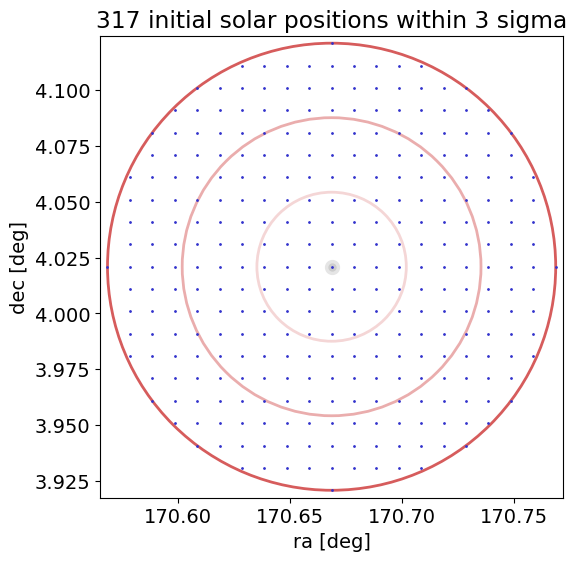

In [161]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(ra_sun_fid/degree,dec_sun_fid/degree,color=(0,0,0,0.1),lw=5);

ellipse_1 = mp.patches.Ellipse(xy=(ra_sun_fid/degree,dec_sun_fid/degree),
                                       width=cos_fac**(-1)*2*sigma_sun/degree, height=2*sigma_sun/degree, 
                                       edgecolor=(0.8,0.2,0.2,0.2), fc='None', lw=2)
ellipse_2 = mp.patches.Ellipse(xy=(ra_sun_fid/degree,dec_sun_fid/degree),
                                       width=cos_fac**(-1)*2*2*sigma_sun/degree, height=2*2*sigma_sun/degree, 
                                       edgecolor=(0.8,0.2,0.2,0.4), fc='None', lw=2)
ellipse_3 = mp.patches.Ellipse(xy=(ra_sun_fid/degree,dec_sun_fid/degree),
                                       width=cos_fac**(-1)*3*2*sigma_sun/degree, height=3*2*sigma_sun/degree, 
                                       edgecolor=(0.8,0.2,0.2,0.8), fc='None', lw=2)
ax.add_patch(ellipse_1); ax.add_patch(ellipse_2); ax.add_patch(ellipse_3);
ax.set_aspect(1);
ax.set_xlim(ra_sun_fid/degree - cos_fac**(-1)*3.1*sigma_sun/degree, ra_sun_fid/degree + cos_fac**(-1)*3.1*sigma_sun/degree)
ax.set_ylim(dec_sun_fid/degree - 3.1*sigma_sun/degree, dec_sun_fid/degree + 3.1*sigma_sun/degree)
ax.scatter(vec_ra_sun_0/degree,vec_dec_sun_0/degree,color=(0.2,0.2,0.8,1),s=1);
ax.set_xlabel('ra [deg]'); ax.set_ylabel('dec [deg]');
ax.set_title(str(len(arr_pos_sun))+' initial solar positions within 3 sigma');

## Event Plot

In [15]:
df_events = load_events(list_file_events)
df_events = df_events[df_events['E']>=3].reset_index(drop=True)
df_events

,detector,t,E,ra,dec
0,A,3.376033e+08,64.84,170.849583,3.925777
1,A,3.376033e+08,27.88,170.995360,3.934654
2,A,3.376033e+08,3.04,171.046690,3.842475
3,A,3.376033e+08,3.00,170.817417,3.916901
4,A,3.376033e+08,70.28,170.924183,3.824722
...,...,...,...,...,...
3012,B,3.376052e+08,83.08,170.959087,3.942165
3013,B,3.376052e+08,3.04,170.807151,3.919632
3014,B,3.376052e+08,29.92,170.922129,3.895051
3015,B,3.376052e+08,4.48,171.040530,3.840426


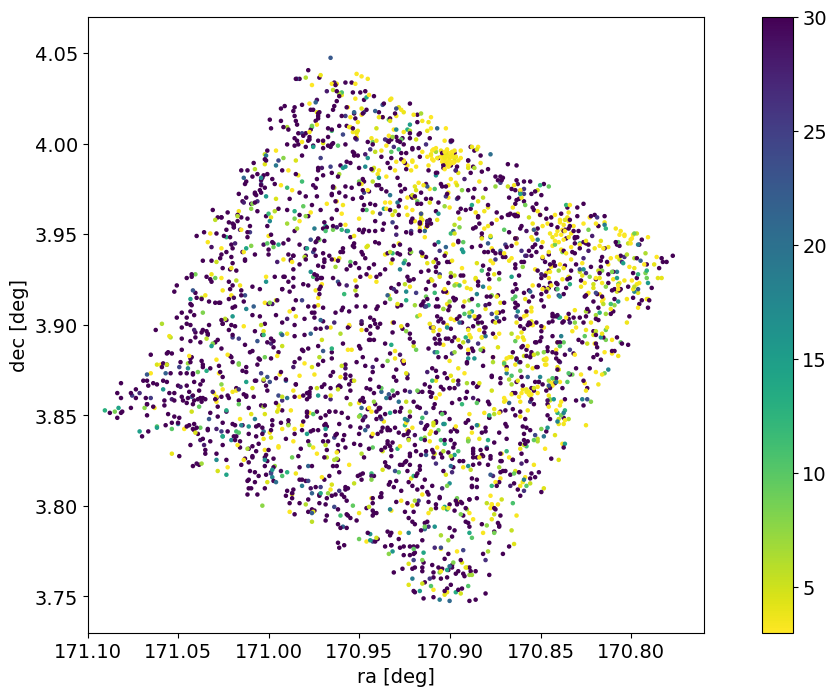

In [84]:
cmap = mp.cm.get_cmap('viridis_r').copy()
fig,ax=plt.subplots(1,1,figsize=(15,8))
sp = ax.scatter(df_events['ra'],df_events['dec'],s=5,c=df_events['E'],cmap=cmap,vmin=3,vmax=30)
delta_FOV = 0.34
center_FOV = [170.93,3.9]
ax.set_xlim(center_FOV[0]+delta_FOV/2,center_FOV[0]-delta_FOV/2);
ax.set_ylim(center_FOV[1]-delta_FOV/2,center_FOV[1]+delta_FOV/2);
ax.set_xlabel('ra [deg]')
ax.set_ylabel('dec [deg]')
ax.set_aspect(1)
fig.colorbar(sp,ax=ax);

In [117]:
df_events_20 = df_events[df_events['E']<=20]

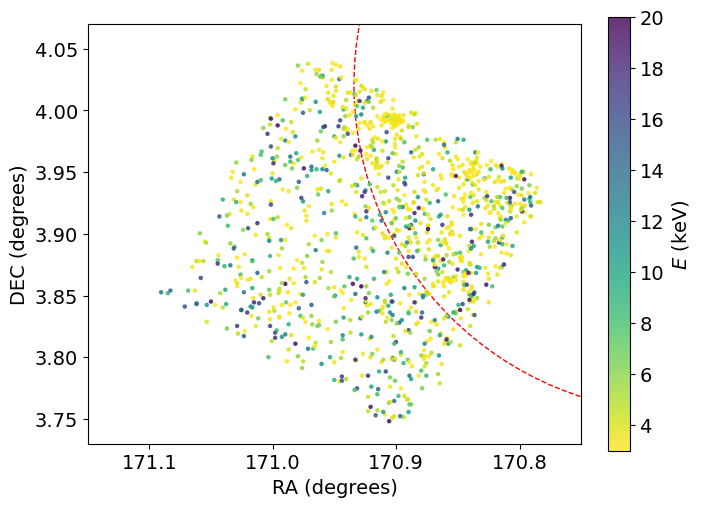

In [119]:
cmap = mp.cm.get_cmap('viridis_r').copy()
fig, ax = plt.subplots(1,1,figsize=(7,7))
ellipse1 = mp.patches.Ellipse((ra_sun_fid/degree,dec_sun_fid/degree), 
                              width=2*RSolar/AU/degree/np.cos(dec_sun_fid*np.pi/180), 
                              height= 2*RSolar/AU/degree,
                              color='red', ls='dashed', fill=False)
ax.add_artist(ellipse1);
sp1 = ax.scatter(df_events_20['ra'],df_events_20['dec'],s = 5, alpha = 0.8, c=(df_events_20['E']),cmap='viridis_r',vmin = 3, vmax = 20)
ax.set_xlabel('RA (degrees)'); ax.set_ylabel('DEC (degrees)');
delta_FOV = 0.34
center_FOV = [170.93,3.9]
ax.set_xlim(center_FOV[0]+delta_FOV/2,center_FOV[0]-delta_FOV/2);
ax.set_ylim(center_FOV[1]-delta_FOV/2,center_FOV[1]+delta_FOV/2);ax.set_xlim(171.15,170.75);
ax.set_aspect(1)
fig.colorbar(sp1,ax=ax,fraction=0.04).set_label('$E$ (keV)')
fig.savefig(dir_fig+'raw_data_scatter.pdf', bbox_inches='tight', pad_inches = 0)